In [1]:
import math
import json
from time import time
from collections import Counter

import numpy as np
import pandas as pd
import sklearn
from sklearn import ensemble, linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pprint as pp
%matplotlib inline

# Cause of Death Prediction
We are given a dataset form wikidata of humans and their various attributes. The task is to classify cause of death. 
There are 4 possible causes of death: *accident, homicide, natural causes, suicide*.

P.S. I only used a sample of the full dataset because the full dataset was 43 GB in size (compressed).

## Main features Selected
These are mostly selected by domain knowledge. Additionally, performing feature selection or dimensionality reduction algorithms are feasible to try in the future since there are many more potential useful features that can provide marginal increase in performance.
- Age
- Century at Birth
- Century at Death
- Sex or Gender
- Country
- Place of Death
- Occupation
- Religion
- Conflict

In [2]:
json_path = "./query_100000.json" # Contains 100,000 people/rows
with open(json_path) as f:
    data = json.load(f)
    
df = pd.DataFrame.from_dict(data)
print(df.shape)
#df = df.sample(5000, axis=0)

(100000, 11)


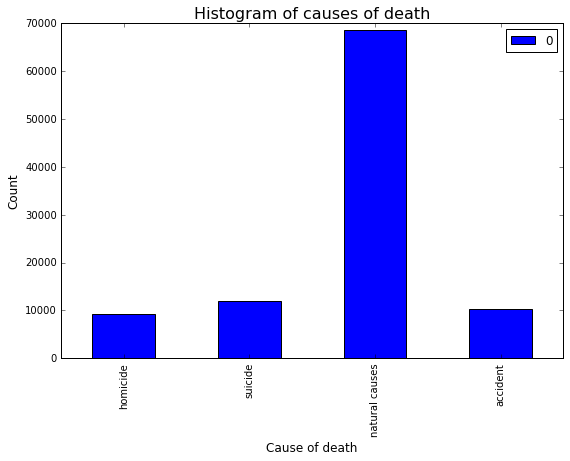

In [3]:
letter_counts = Counter(df['cause'].tolist())
df_count = pd.DataFrame.from_dict(letter_counts, orient='index')
df_count.plot(kind='bar', figsize=(9, 6))
plt.title("Histogram of causes of death", fontsize=16)
plt.xlabel("Cause of death", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Feature Engineering:

In [4]:
df.head()

,cause,conflict,country,date_of_birth,date_of_death,human,number_of_children,occupation,place_of_death,religion,sex_or_gender
0,suicide,http://www.wikidata.org/entity/Q989115,Kingdom of Italy,1873-04-22T00:00:00Z,1910-10-19T00:00:00Z,Luigi Lucheni,NaN,http://www.wikidata.org/entity/Q14886050,http://www.wikidata.org/entity/Q71,NaN,http://www.wikidata.org/entity/Q6581097
1,suicide,NaN,Japan,1909-06-19T00:00:00Z,1948-06-13T00:00:00Z,Osamu Dazai,NaN,http://www.wikidata.org/entity/Q6625963,http://www.wikidata.org/entity/Q7473516,NaN,http://www.wikidata.org/entity/Q6581097
2,suicide,NaN,South Korea,1955-02-24T00:00:00Z,1982-04-27T00:00:00Z,Woo Bum-kon,NaN,http://www.wikidata.org/entity/Q15883433,http://www.wikidata.org/entity/Q50316,NaN,http://www.wikidata.org/entity/Q6581097
3,suicide,NaN,South Korea,1956-08-31T00:00:00Z,2018-07-23T00:00:00Z,Roh Hoe-chan,NaN,http://www.wikidata.org/entity/Q1930187,http://www.wikidata.org/entity/Q8684,NaN,http://www.wikidata.org/entity/Q6581097
4,suicide,NaN,South Korea,1989-05-31T00:00:00Z,2009-11-19T00:00:00Z,Daul Kim,NaN,http://www.wikidata.org/entity/Q3357567,http://www.wikidata.org/entity/Q90,NaN,http://www.wikidata.org/entity/Q6581072


In [5]:
df['year_of_death'] = pd.to_numeric(df['date_of_death'].str[:4], errors='coerce', downcast='integer')
df['year_of_birth'] = pd.to_numeric(df['date_of_birth'].str[:4], errors='coerce', downcast='integer')
df['century_at_birth'] = (df['year_of_birth'] / 100).round().astype('int', errors='ignore')
df['century_at_death'] = (df['year_of_death'] / 100).round().astype('int', errors='ignore')
df['age_at_death'] = (df['year_of_death'] - df['year_of_birth']) / 100.
df['is_conflict'] = float('nan')
df['is_conflict'][df['conflict'].notnull()] = 1

/Users/Anuar_The_Great/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
"""
*DON'T RUN THIS CELL!*
The code in this cell fetches value from the wiki page given the url in the json file.
THIS IS ONLY USED IN DATA EXPLORATION!  We can create features without using semantic information.
"""
def get_value_from_url(url):
    if type(url) == float and math.isnan(url): return url
    start_time = time()
    response = requests.get(url)
    if response.status_code != 200: return float('nan')
    #print("Time taken: ", time() - start_time)
    data = response.content
    soup = BeautifulSoup(data, "lxml")
    parsed_str = str(soup.html.body.p.contents[0])
    parsed_dict = json.loads(parsed_str)
    value_id = url.split('/')[-1]
    value = parsed_dict['entities'][value_id]['labels']['en']['value']
    return value

df['gender_parsed'] = df['sex_or_gender'].apply(get_value_from_url)
df['occupation_parsed'] = df['occupation'].apply(get_value_from_url)
df['place_of_death_parsed'] = df['place_of_death'].apply(get_value_from_url)
df['religion_parsed'] = df['religion'].apply(get_value_from_url)

In [6]:
"""
# NOTE: Initially slow version in this cell, see next cell for realtime version!
"""
def replace_low_count_feats(df, field_name, thresh=5):
    """
    Due to the fact that the number of features explodes during 
    one-hot encoding, we 'pad' values with count<thresh to NaN.
    """
    value_counts = df[field_name].value_counts()
    value_counts[float('nan')] = 0
    for i, row in df.iterrows():
        field = row[field_name]
        if type(field) == float and math.isnan(field):
            continue
        else:
            count = value_counts[field]
            if count < thresh:
                df[field_name][i] = float('nan')
    return df

In [ ]:
"""
*DON'T RUN THIS CELL!*
# NOTE: Initially slow version in this cell, see next cell for realtime version!
"""
print("Before: ", df['occupation'].unique().shape, df['place_of_death'].unique().shape,
      df['country'].unique().shape, df['religion'].unique().shape)
df = replace_low_count_feats(df, "occupation", thresh=30)
df = replace_low_count_feats(df, "place_of_death", thresh=30)
df = replace_low_count_feats(df, "country", thresh=30)
df = replace_low_count_feats(df, "religion", thresh=30)
print("After: ", df['occupation'].unique().shape, df['place_of_death'].unique().shape,
      df['country'].unique().shape, df['religion'].unique().shape)

In [7]:
def for_apply(x, value_counts=None, thresh=10):
    if type(x) == float and math.isnan(x):
        return float('nan')
    else:
        count = value_counts[x]
        if count < thresh:
            return float('nan')
        else:
            return x
        
df['occupation'] = df['occupation'].apply(for_apply, value_counts=df['occupation'].value_counts(), thresh=30)       
df['place_of_death'] = df['place_of_death'].apply(for_apply, value_counts=df['place_of_death'].value_counts(), thresh=30)
df['country'] = df['country'].apply(for_apply, value_counts=df['country'].value_counts(), thresh=30)
df['religion'] = df['religion'].apply(for_apply, value_counts=df['religion'].value_counts(), thresh=30)

In [8]:
%timeit -n 1 -r 1 replace_low_count_feats(df, "religion", thresh=30)
%timeit df['religion'].apply(for_apply, value_counts=df['religion'].value_counts(), thresh=30)

1 loop, best of 1: 8.92 s per loop
1 loop, best of 3: 244 ms per loop


In [9]:
# Preparing labels
le = preprocessing.LabelEncoder()
le.fit(df['cause'])
labels = le.transform(df['cause'])
uniques, counts = np.unique(labels, return_counts=True)
print(list(le.classes_))
print(uniques, counts)

[u'accident', u'homicide', u'natural causes', u'suicide']
(array([0, 1, 2, 3]), array([10245,  9217, 68588, 11950]))


In [10]:
one_hot_gender = pd.get_dummies(df['sex_or_gender'], dummy_na=True)
one_hot_occupation = pd.get_dummies(df['occupation'], dummy_na=True)
one_hot_place_of_death = pd.get_dummies(df['place_of_death'], dummy_na=True)
one_hot_country = pd.get_dummies(df['country'], dummy_na=True)
one_hot_religion = pd.get_dummies(df['religion'], dummy_na=True)
one_hot_conflict = pd.get_dummies(df['religion'], dummy_na=True)

print("Shapes of one-hot encoded features: ")
print(one_hot_gender.shape, one_hot_occupation.shape, one_hot_place_of_death.shape,
      one_hot_country.shape, one_hot_religion.shape, one_hot_conflict.shape)

features = np.concatenate((np.nan_to_num(np.array(df['age_at_death'])[:, None]),
                           np.nan_to_num(np.array(df['century_at_birth'])[:, None]),
                           np.nan_to_num(np.array(df['century_at_death'])[:, None]),), axis=1)
features = np.concatenate((features,
                           one_hot_gender,
                           one_hot_occupation,
                           one_hot_place_of_death,
                           one_hot_country,
                           one_hot_religion), axis=1)
#labels = pd.get_dummies(df['cause'])
assert(labels.shape[0] == features.shape[0])
print("features.shape: ", features.shape)

Shapes of one-hot encoded features: 
((100000, 6), (100000, 276), (100000, 360), (100000, 158), (100000, 50), (100000, 50))
('features.shape: ', (100000, 853))


In [11]:
X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(
            features, labels, test_size=0.3, random_state=0, stratify=labels)
X_val, X_test, y_val, y_test = model_selection.train_test_split(
            X_val_test, y_val_test, test_size=0.6667, random_state=0, stratify=y_val_test)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)
print("Number of samples in train/val/test split: %d/%d/%d" % (y_train.shape[0], y_val.shape[0], y_test.shape[0]))

((70000, 853), (9999, 853), (20001, 853), (70000,), (9999,), (20001,))
Number of samples in train/val/test split: 70000/9999/20001


# Modelling
I try 3 different models that usually prove to be the most effective and can solve the problem in tractable time:
- Logistic Regression
- Support Vector Machine (with linear kernel)
- Random Forest

Hyperparameters are fine-tuned on the validation set without looking into the test set.

In [12]:
clf_LR = linear_model.LogisticRegression(penalty='l1', random_state=0, solver='liblinear',
                                         multi_class='ovr')
clf_LR.fit(X_train, y_train)
preds_train = clf_LR.predict(X_train)
preds_val = clf_LR.predict(X_val)
acc_train = metrics.accuracy_score(y_train, preds_train)
acc_val = metrics.accuracy_score(y_val, preds_val)
print("Train Set Accuracy: %.1f%%" % (acc_train*100))
print("Validation Set Accuracy: %.1f%%" % (acc_val*100))

Train Set Accuracy: 73.9%
Validation Set Accuracy: 73.0%


In [13]:
from sklearn import svm
clf_SVC = svm.LinearSVC(dual=False, C=1., random_state=0, tol=1e-6, verbose=3, max_iter=10000)
clf_SVC.fit(X_train, y_train)
preds_train = clf_SVC.predict(X_train)
preds_val = clf_SVC.predict(X_val)
acc_train = metrics.accuracy_score(y_train, preds_train)
acc_val = metrics.accuracy_score(y_val, preds_val)
print("Train Set Accuracy: %.1f%%" % (acc_train*100))
print("Validation Set Accuracy: %.1f%%" % (acc_val*100))

[LibLinear]Train Set Accuracy: 73.5%
Validation Set Accuracy: 72.8%


In [14]:
clf_RF = ensemble.RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0)
clf_RF.fit(X_train, y_train)
preds_train = clf_RF.predict(X_train)
preds_val = clf_RF.predict(X_val)
acc_train = metrics.accuracy_score(y_train, preds_train)
acc_val = metrics.accuracy_score(y_val, preds_val)
print("Train Set Accuracy: %.1f%%" % (acc_train*100))
print("Validation Set Accuracy: %.1f%%" % (acc_val*100))

Train Set Accuracy: 68.6%
Validation Set Accuracy: 68.6%


# Results

In [15]:
preds_LR = clf_LR.predict(X_test)
preds_SVC = clf_SVC.predict(X_test)
preds_RF = clf_RF.predict(X_test)

acc_LR = metrics.accuracy_score(y_test, preds_LR)
acc_SVC = metrics.accuracy_score(y_test, preds_SVC)
acc_RF = metrics.accuracy_score(y_test, preds_RF)
print("Logistic Regression Test Set Accuracy: %.1f%%" % (acc_LR*100))
print("Linear SVM Test Set Accuracy: %.1f%%" % (acc_SVC*100))
print("Random Forest Test Set Accuracy: %.1f%%\n" % (acc_RF*100))

print(metrics.classification_report(y_test, preds_LR, target_names=le.classes_))
print(metrics.classification_report(y_test, preds_SVC, target_names=le.classes_))
print(metrics.classification_report(y_test, preds_RF, target_names=le.classes_))

Logistic Regression Test Set Accuracy: 73.5%
Linear SVM Test Set Accuracy: 73.0%
Random Forest Test Set Accuracy: 68.6%

                precision    recall  f1-score   support

      accident       0.54      0.21      0.31      2050
      homicide       0.57      0.40      0.47      1843
natural causes       0.77      0.95      0.85     13718
       suicide       0.47      0.19      0.27      2390

   avg / total       0.69      0.74      0.69     20001

                precision    recall  f1-score   support

      accident       0.61      0.16      0.26      2050
      homicide       0.56      0.37      0.45      1843
natural causes       0.75      0.97      0.85     13718
       suicide       0.52      0.13      0.20      2390

   avg / total       0.69      0.73      0.67     20001

                precision    recall  f1-score   support

      accident       0.00      0.00      0.00      2050
      homicide       0.00      0.00      0.00      1843
natural causes       0.69      1

/Users/Anuar_The_Great/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### The most accurate model both by accuracy and by F1-score (which is balanced metric) is: **Logistic Regression**
In comparison, RF overfit which is evident of its 0.56 F1-score while Logistic Regression has 0.69 F1-score.  
SVM is slightly lower in accuracy and F1-score than Logistic Regression.

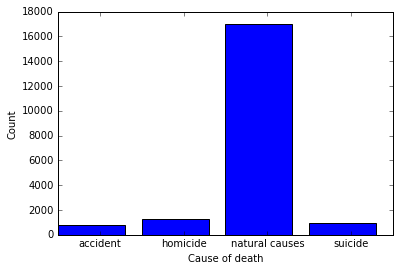

In [16]:
# In order to make sure classifier doesn't learn only specific labels
uniques, counts = np.unique(preds_LR, return_counts=True)
plt.bar(uniques, counts)
plt.xticks(uniques+0.5, le.classes_)
plt.xlabel("Cause of death")
plt.ylabel("Count")

# Additional Improvements in the future
Instead of naively encoding the features into one-hot encoded vectors we could create an embedding and learn it with a neural network. We would have an embedding layer and then several fully-connected layers with ReLU non-linearity and batch-normalization. This will solve curse of dimensionality problem and will probably generalize better.
